In [2]:
import os 
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import zip_longest
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/FS_TCG')
import utils_results as ut

In [3]:
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')

In [4]:
METRIC = 'R' # 'MAE', 'RMSE', 'R2', 'R', 'COMB' (this rescales all 4 previous metrics and combines them in a unique quantitative metric), 'R2adj' seems very weird

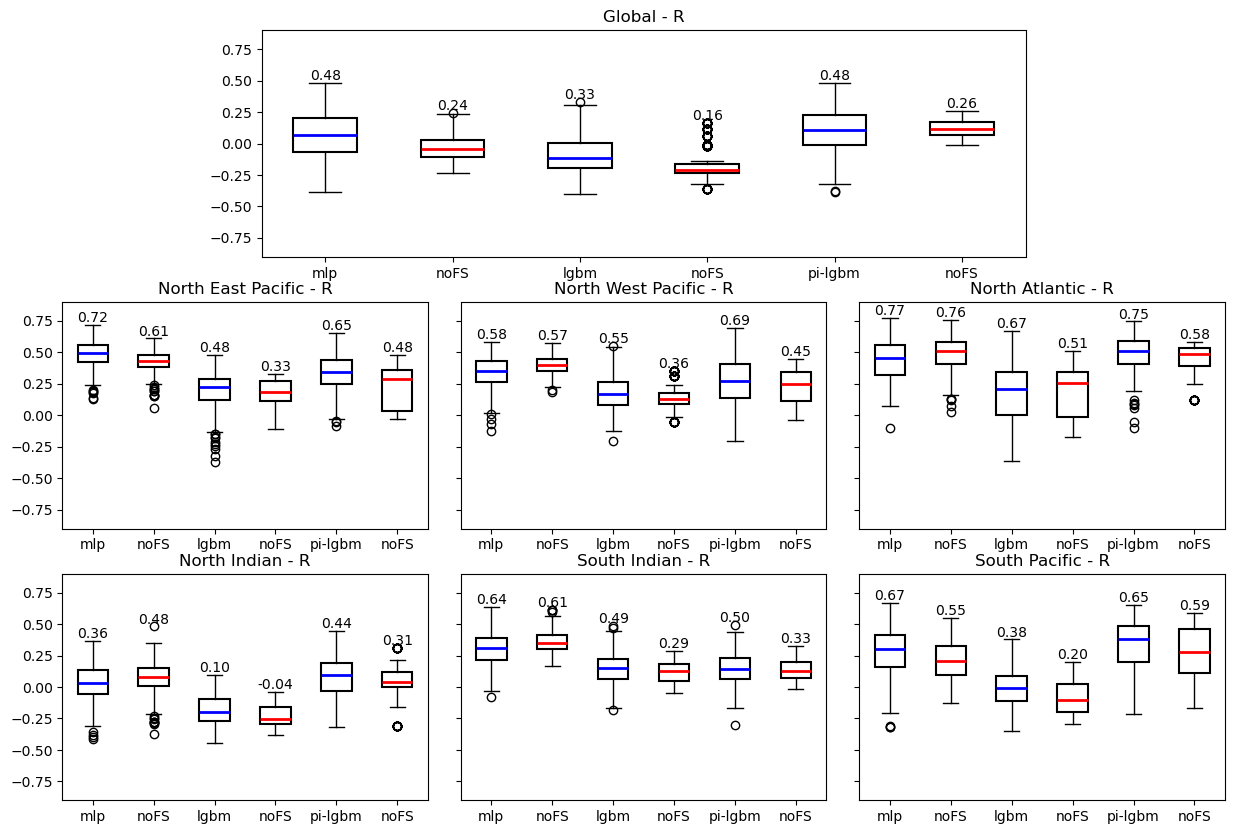

In [5]:
fmod_boxplot_fig = plt.figure(figsize=(15, 10))
fmod_gs = gridspec.GridSpec(3, 6, figure=fmod_boxplot_fig)
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
for bb, basin in enumerate(['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']):
    # Load file keeping track of the performance of the simulations
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Cycle through the different finals models
    performance_arrays = []
    best_values = []
    if METRIC == 'COMB':
        higher_is_better = ['R_Y_mlp', 'R_Y_lgbm', 'R_Y_pi-lgbm', 'R_Y_mlp_noFS', 'R_Y_lgbm_noFS', 'R_Y_pi-lgbm_noFS',
                            'R2_Y_mlp', 'R2_Y_lgbm', 'R2_Y_pi-lgbm', 'R2_Y_mlp_noFS', 'R2_Y_lgbm_noFS', 'R2_Y_pi-lgbm_noFS']
        lower_is_better = ['MAE_Y_mlp', 'MAE_Y_lgbm', 'MAE_Y_pi-lgbm', 'MAE_Y_mlp_noFS', 'MAE_Y_lgbm_noFS', 'MAE_Y_pi-lgbm_noFS',
                            'RMSE_Y_mlp', 'RMSE_Y_lgbm', 'RMSE_Y_pi-lgbm', 'RMSE_Y_mlp_noFS', 'RMSE_Y_lgbm_noFS', 'RMSE_Y_pi-lgbm_noFS']
        performance_col = ['COMB_Y_mlp', 'COMB_Y_mlp_noFS', 'COMB_Y_lgbm', 'COMB_Y_lgbm_noFS', 'COMB_Y_pi-lgbm', 'COMB_Y_pi-lgbm_noFS']
        for perf_col in performance_col:
            track_df[perf_col] = np.zeros(len(track_df))
        columns_metrics = higher_is_better + lower_is_better
        for column in columns_metrics:
            model_col = column.split('Y_')[1]
            if column in higher_is_better:
                track_df[f'COMB_Y_{model_col}'] += (track_df[column] - track_df[column].min()) / (track_df[column].max() - track_df[column].min())
            else:
                track_df[f'COMB_Y_{model_col}'] += (track_df[column].max() - track_df[column]) / (track_df[column].max() - track_df[column].min())
        for performance in performance_col:
            sorted_df = track_df.sort_values(performance, ascending=False)
            performance_arrays.append(sorted_df[performance].values)
            best_values.append(sorted_df[performance].values[0])
    else:
        performance_col = [f'{METRIC}_Y_mlp', f'{METRIC}_Y_mlp_noFS', f'{METRIC}_Y_lgbm', f'{METRIC}_Y_lgbm_noFS', f'{METRIC}_Y_pi-lgbm', f'{METRIC}_Y_pi-lgbm_noFS']
        for performance in performance_col:
            if METRIC == 'MAE' or METRIC == 'RMSE':
                sorted_df = track_df.sort_values(performance, ascending=True)
            else:
                sorted_df = track_df.sort_values(performance, ascending=False)
            performance_arrays.append(sorted_df[performance].values)
            best_values.append(sorted_df[performance].values[0])
    # Plot the boxplot of the performance of the simulations
    if basin == 'GLB':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[0,1:5])
    elif basin == 'NEP':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[1,0:2])
    elif basin == 'NWP':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[1,2:4])
        ax.set_yticklabels([])
    elif basin == 'NA':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[1,4:])
        ax.set_yticklabels([])
    elif basin == 'NI':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[2,0:2])
    elif basin == 'SI':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[2,2:4])
        ax.set_yticklabels([])
    elif basin == 'SP':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[2,4:])
        ax.set_yticklabels([])
    box = ax.boxplot(performance_arrays, labels=['mlp', 'noFS', 'lgbm', 'noFS', 'pi-lgbm', 'noFS'],
                        showfliers=True, patch_artist=True)
    colors = ["blue", "red", "blue", "red", "blue", "red", "blue", "red"]
    for median, color in zip(box['medians'], colors):
        median.set(color=color, linewidth=2)
    for b in box['boxes']:
        b.set(facecolor='white', edgecolor='black', linewidth=1.5)
    # Add the best performance values to the plot
    for i, value in enumerate(best_values):
        if METRIC == 'MAE' or METRIC == 'RMSE':
            ax.text(i+1, value, f'{value:.2f}', ha='center', va='top', fontsize=10)
        else:
            ax.text(i+1, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{basin_names[bb]} - {METRIC}')
    if METRIC == 'R':
        ax.set_ylim([-0.9, 0.9]);
    elif METRIC == 'COMB':
        ax.set_ylim([-0.5, 5]);

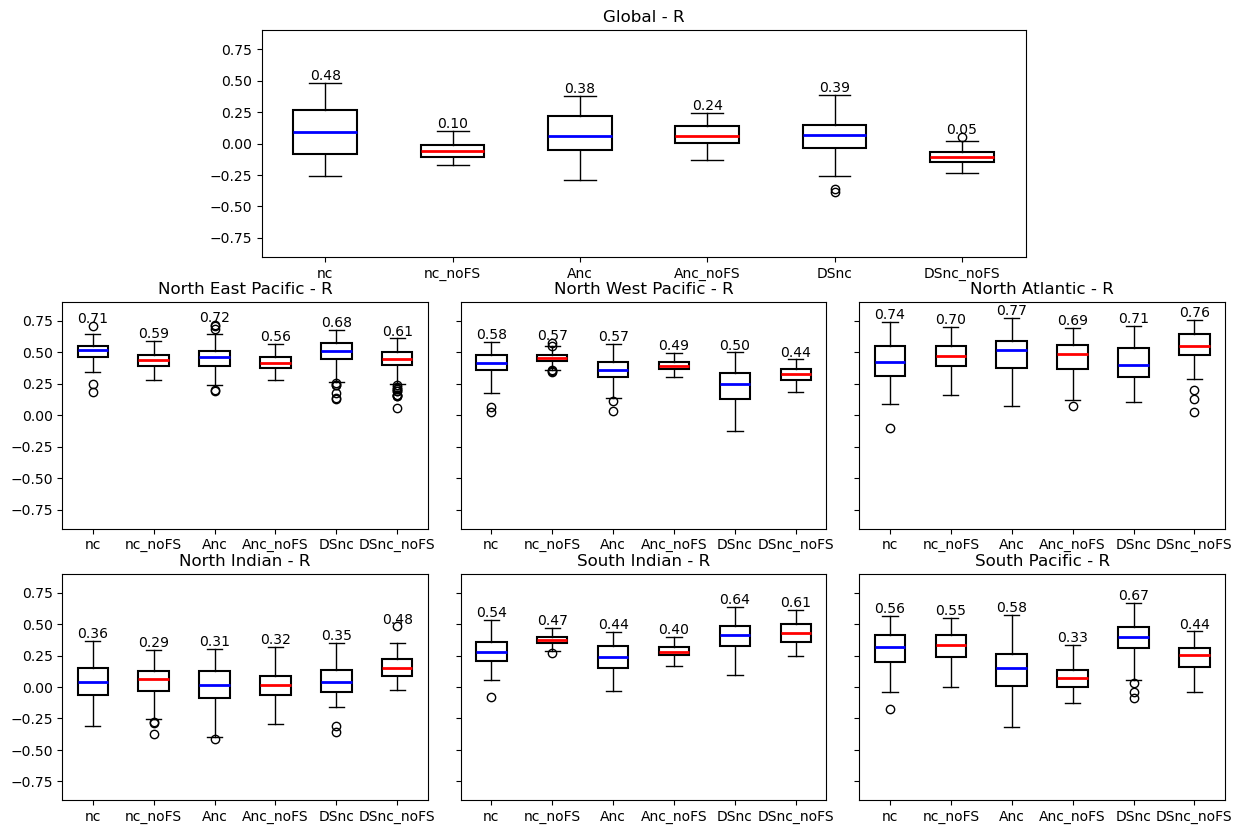

In [6]:
FINAL_MODEL = 'mlp'
# Boxplot considering the different cluster types
cltype_boxplot_fig = plt.figure(figsize=(15, 10))
cltype_gs = gridspec.GridSpec(3, 6, figure=cltype_boxplot_fig)
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
for bb, basin in enumerate(['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']):
    # Load file keeping track of the performance of the simulations
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Sort the dataframe by the performance of the chosen final model
    if METRIC == 'COMB':
        higher_is_better = [f'R_Y_{FINAL_MODEL}', f'R_Y_{FINAL_MODEL}_noFS', f'R2_Y_{FINAL_MODEL}', f'R2_Y_{FINAL_MODEL}_noFS']
        lower_is_better = [f'MAE_Y_{FINAL_MODEL}', f'MAE_Y_{FINAL_MODEL}_noFS', f'RMSE_Y_{FINAL_MODEL}', f'RMSE_Y_{FINAL_MODEL}_noFS']
        performance_col = f'COMB_Y_{FINAL_MODEL}'
        performance_col_noFS = f'COMB_Y_{FINAL_MODEL}_noFS'
        track_df[performance_col] = np.zeros(len(track_df))
        track_df[performance_col_noFS] = np.zeros(len(track_df))
        columns_metrics = higher_is_better + lower_is_better
        for column in columns_metrics:
            model_col = column.split('Y_')[1]
            if column in higher_is_better:
                track_df[f'COMB_Y_{model_col}'] += (track_df[column] - track_df[column].min()) / (track_df[column].max() - track_df[column].min())
            else:
                track_df[f'COMB_Y_{model_col}'] += (track_df[column].max() - track_df[column]) / (track_df[column].max() - track_df[column].min())
        sorted_df = track_df.sort_values(performance_col, ascending=False)
        sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=False)
    else:
        performance_col = f'{METRIC}_Y_{FINAL_MODEL}'
        performance_col_noFS = f'{METRIC}_Y_{FINAL_MODEL}_noFS'
        if METRIC == 'MAE' or METRIC == 'RMSE':
            sorted_df = track_df.sort_values(performance_col, ascending=True)
            sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=True)
        else:
            sorted_df = track_df.sort_values(performance_col, ascending=False)
            sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=False)
    # Extract the simulation considering the 3 different cluster types
    sorted_df_nc = sorted_df[sorted_df.index.str.contains('_nc')]
    sorted_df_Anc = sorted_df[sorted_df.index.str.contains('_Anc')]
    sorted_df_DSnc = sorted_df[sorted_df.index.str.contains('_DSnc')]
    sorted_df_noFS_nc = sorted_df_noFS[sorted_df_noFS.index.str.contains('_nc')]
    sorted_df_noFS_Anc = sorted_df_noFS[sorted_df_noFS.index.str.contains('_Anc')]
    sorted_df_noFS_DSnc = sorted_df_noFS[sorted_df_noFS.index.str.contains('_DSnc')]
    # Get the best performance values for each cluster type
    best_values = [
        sorted_df_nc.iloc[0][performance_col], sorted_df_noFS_nc.iloc[0][performance_col_noFS],
        sorted_df_Anc.iloc[0][performance_col], sorted_df_noFS_Anc.iloc[0][performance_col_noFS],
        sorted_df_DSnc.iloc[0][performance_col], sorted_df_noFS_DSnc.iloc[0][performance_col_noFS]
    ]
    # Plot the boxplot of the performance of the simulations
    if basin == 'GLB':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[0,1:5])
    elif basin == 'NEP':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[1,0:2])
    elif basin == 'NWP':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[1,2:4])
        ax.set_yticklabels([])
    elif basin == 'NA':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[1,4:])
        ax.set_yticklabels([])
    elif basin == 'NI':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[2,0:2])
    elif basin == 'SI':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[2,2:4])
        ax.set_yticklabels([])
    elif basin == 'SP':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[2,4:])
        ax.set_yticklabels([])
    box = ax.boxplot([sorted_df_nc[performance_col].values, sorted_df_noFS_nc[performance_col_noFS].values,
                        sorted_df_Anc[performance_col].values, sorted_df_noFS_Anc[performance_col_noFS].values,
                        sorted_df_DSnc[performance_col].values, sorted_df_noFS_DSnc[performance_col_noFS].values],
                        labels=['nc', 'nc_noFS', 'Anc', 'Anc_noFS', 'DSnc', 'DSnc_noFS'],
                        showfliers=True, patch_artist=True)
    colors = ["blue", "red", "blue", "red", "blue", "red"]
    for median, color in zip(box['medians'], colors):
        median.set(color=color, linewidth=2)
    for b in box['boxes']:
        b.set(facecolor='white', edgecolor='black', linewidth=1.5)
    # Add the best performance values to the plot
    for i, value in enumerate(best_values):
        if METRIC == 'MAE' or METRIC == 'RMSE':
            ax.text(i+1, value, f'{value:.2f}', ha='center', va='top', fontsize=10)
        else:
            ax.text(i+1, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{basin_names[bb]} - {METRIC}')
    if METRIC == 'R2adj' or METRIC == 'R':
        ax.set_ylim([-0.9, 0.9]);
    elif METRIC == 'COMB':
        ax.set_ylim([-0.5, 5]);
# cltype_boxplot_fig.suptitle(f'Annual correlation performances of NN models for the different cluster types', fontsize=14);

1. R - annual correlation
- _nc -> GLB, NWP, NI
- Anc -> NEP, NA
- DSnc -> SI, SP
2. MAE - annual mean absolute error
- _nc -> GLB, NWP, NI, SP, NEP
- Anc -> NA
- DSnc -> SI
3. RMSE - annual root mean squared error 
- _nc -> GLB, NWP, NI, SP
- Anc -> NA
- DSnc -> NEP, SI
4. R2 - annual coefficient of determination
- _nc -> GLB, NEP, NWP, NI
- Anc -> NA
- DSnc -> SI, SP
5. COMB - rescaled combination of 4 previous metrics
- _nc -> GLB, NEP, NWP, NI
- Anc -> NA
- DSnc -> SI, SP

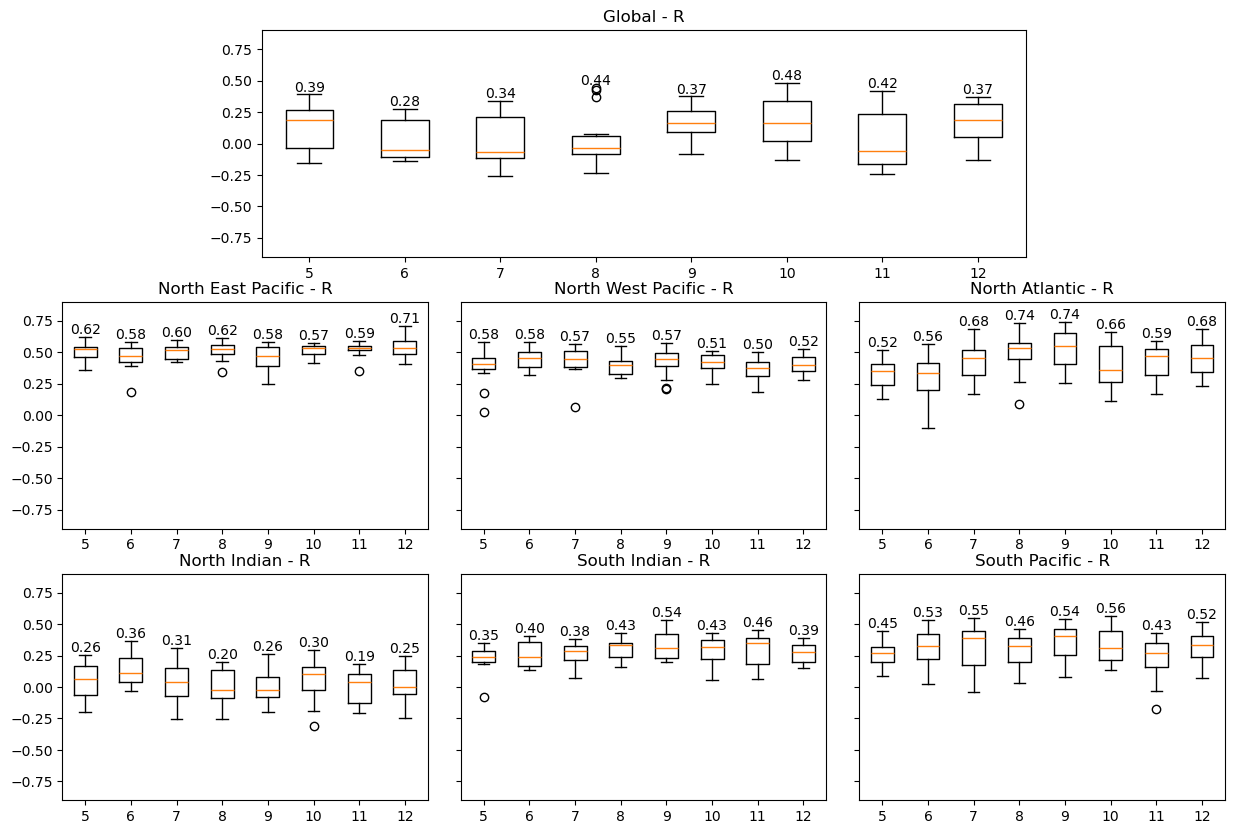

In [20]:
CLUSTER_TYPE = '_nc' # _nc, Anc, DSnc
# Boxplot considering the number of clusters
ncl_boxplot_fig = plt.figure(figsize=(15, 10))
ncle_gs = gridspec.GridSpec(3, 6, figure=ncl_boxplot_fig)
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
for bb, basin in enumerate(['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']):
    # Load file keeping track of the performance of the simulations
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Filter the track_df to keep only simulations with the anomaly cluster type
    track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
    # Sort the dataframe by the performance of the chosen final model
    if METRIC == 'COMB':
        higher_is_better = [f'R_Y_{FINAL_MODEL}', f'R2_Y_{FINAL_MODEL}']
        lower_is_better = [f'MAE_Y_{FINAL_MODEL}', f'RMSE_Y_{FINAL_MODEL}']
        performance_col = f'COMB_Y_{FINAL_MODEL}'
        track_df[performance_col] = np.zeros(len(track_df))
        columns_metrics = higher_is_better + lower_is_better
        for column in columns_metrics:
            model_col = column.split('Y_')[1]
            if column in higher_is_better:
                track_df[f'COMB_Y_{model_col}'] += (track_df[column] - track_df[column].min()) / (track_df[column].max() - track_df[column].min())
            else:
                track_df[f'COMB_Y_{model_col}'] += (track_df[column].max() - track_df[column]) / (track_df[column].max() - track_df[column].min())
        sorted_df = track_df.sort_values(performance_col, ascending=False)
    else:
        performance_col = f'{METRIC}_Y_{FINAL_MODEL}'
        if METRIC == 'MAE' or METRIC == 'RMSE':
            sorted_df = track_df.sort_values(performance_col, ascending=True)
        else:
            sorted_df = track_df.sort_values(performance_col, ascending=False)
    # Cycle through the number of clusters and extract the data to plot the boxplot
    performances_arrays = []
    best_values = []
    for ncl in range(5, 13):
        ncl_df = sorted_df[sorted_df['n_clusters'] == ncl]
        performances_arrays.append(ncl_df[performance_col].values)
        best_values.append(ncl_df.iloc[0][performance_col])
    # Plot the boxplot of the performance of the simulations
    if basin == 'GLB':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[0,1:5])
    elif basin == 'NEP':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[1,0:2])
    elif basin == 'NWP':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[1,2:4])
        ax.set_yticklabels([])
    elif basin == 'NA':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[1,4:])
        ax.set_yticklabels([])
    elif basin == 'NI':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[2,0:2])
    elif basin == 'SI':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[2,2:4])
        ax.set_yticklabels([])
    elif basin == 'SP':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[2,4:])
        ax.set_yticklabels([])
    box = ax.boxplot(performances_arrays, labels=[str(i) for i in range(5, 13)], showfliers=True, patch_artist=False)
    # colors = ["blue", "red", "blue", "red", "blue", "red"]
    # for median, color in zip(box['medians'], colors):
    #     median.set(color=color, linewidth=2)
    # for b in box['boxes']:
    #     b.set(facecolor='white', edgecolor='black', linewidth=1.5)
    # Add the best performance values to the plot
    for i, value in enumerate(best_values):
        if METRIC == 'MAE' or METRIC == 'RMSE':
            ax.text(i+1, value, f'{value:.2f}', ha='center', va='top', fontsize=10)
        else:
            ax.text(i+1, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{basin_names[bb]} - {METRIC}')
    if METRIC == 'R2' or METRIC == 'R2adj' or METRIC == 'R':
        ax.set_ylim([-0.9, 0.9]);
    elif METRIC == 'COMB':
        ax.set_ylim([-0.5, 5]);

In [21]:
BASIN = 'GLB'
N_CLUSTERS = 10
# Load the performance file for the basin and filter to get the simulation with the best performance
track_file = os.path.join(results_dir, f'sim_performance_{BASIN}.csv')
track_df = pd.read_csv(track_file, index_col=0)
track_df = track_df[track_df.index.str.contains('nd9')]
track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
track_df = track_df[track_df['n_clusters'] == N_CLUSTERS]
# Get the simulation with the best performance
if METRIC == 'COMB':
    higher_is_better = [f'R_Y_{FINAL_MODEL}', f'R_Y_{FINAL_MODEL}_noFS', f'R2_Y_{FINAL_MODEL}', f'R2_Y_{FINAL_MODEL}_noFS']
    lower_is_better = [f'MAE_Y_{FINAL_MODEL}', f'MAE_Y_{FINAL_MODEL}_noFS', f'RMSE_Y_{FINAL_MODEL}', f'RMSE_Y_{FINAL_MODEL}_noFS']
    performance_col = f'COMB_Y_{FINAL_MODEL}'
    performance_col_noFS = f'COMB_Y_{FINAL_MODEL}_noFS'
    track_df[performance_col] = np.zeros(len(track_df))
    track_df[performance_col_noFS] = np.zeros(len(track_df))
    columns_metrics = higher_is_better + lower_is_better
    for column in columns_metrics:
        model_col = column.split('Y_')[1]
        if column in higher_is_better:
            track_df[f'COMB_Y_{model_col}'] += (track_df[column] - track_df[column].min()) / (track_df[column].max() - track_df[column].min())
        else:
            track_df[f'COMB_Y_{model_col}'] += (track_df[column].max() - track_df[column]) / (track_df[column].max() - track_df[column].min())
    sorted_df = track_df.sort_values(performance_col, ascending=False)
else:
    performance_col = f'{METRIC}_Y_{FINAL_MODEL}'
    if METRIC == 'MAE' or METRIC == 'RMSE':
        sorted_df = track_df.sort_values(performance_col, ascending=True)
    else:
        sorted_df = track_df.sort_values(performance_col, ascending=False)
best_sim = sorted_df.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters: {best_sim.name} - {METRIC}_Y: {best_sim[f"{METRIC}_Y_{FINAL_MODEL}"]:.2f}')
# Get the best annual correlation for a model with no features selection
sorted_df_noFS = track_df.sort_values(f'R_Y_{FINAL_MODEL}_noFS', ascending=False)
best_sim_noFS = sorted_df_noFS.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters and no FS: {best_sim_noFS.name} - {METRIC}_Y: {best_sim_noFS[f"{METRIC}_Y_{FINAL_MODEL}_noFS"]:.2f}')

Best NN model for GLB with 10 clusters: test2_linreg_nc10_nv8_nd9 - R_Y: 0.48
Best NN model for GLB with 10 clusters and no FS: test4_lgbm_nc10_nv8_nd9 - R_Y: 0.06


In [22]:
nc_string = best_sim.name.split('_')[2]
if "A" in nc_string:
    cluster_data = f'{BASIN}_{N_CLUSTERS}clusters_anomaly'
elif "DS" in nc_string:
    cluster_data = f'{BASIN}_{N_CLUSTERS}clusters_deseason'
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
else:
    cluster_data = f'{BASIN}_{N_CLUSTERS}clusters'
# Set the paths to files
experiment_filename = f'1970-2022_{N_CLUSTERS}clusters_8vars_9idxs.csv'
predictor_file = 'predictors_' + experiment_filename
data_dir = os.path.join(fs_dir, 'data', cluster_data)
predictors_path = os.path.join(data_dir, predictor_file)
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
candidate_variables = predictors_df.columns.to_numpy()
target_file = 'target_1970-2022_2.5x2.5.csv'
target_path = os.path.join(data_dir, target_file)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)


In [23]:
# df_selection = pd.DataFrame(columns=candidate_variables, index=sorted_df.index)
# for run_name in df_selection.index:
#     model_kind = run_name.split('_')[1]
#     sol_filename = f'{model_kind}_{experiment_filename}'
#     output_dir = os.path.join(fs_dir, 'results', BASIN, run_name)
#     best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
#     best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
#     best_solution = best_solution.to_numpy().flatten()
#     # Select the variables from the best solutions
#     column_names = predictors_df.columns.tolist()
#     feat_sel = best_solution[2*len(column_names):]
#     df_selection.loc[run_name] = feat_sel

# df_selection = df_selection.apply(pd.to_numeric, errors='coerce')

# plt.figure(figsize=(3*N_CLUSTERS, 10))
# ax = sns.heatmap(df_selection, cmap="Blues", linewidths=0.5, linecolor="gray", cbar=False, square=True)

# # Set xticks labels
# features_clustered = [var for var in candidate_variables if 'cluster' in var]
# features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
# cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
# variables = [col.split("_cluster")[0] for col in features_clustered]
# variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
# xticks_labels = cluster_numbers + features_non_clustered
# ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
# ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=10)
# for i, var in enumerate(sorted(set(variables), key=variables.index)):
#     xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + N_CLUSTERS/2
#     ax.text(xpos, len(df_selection) + 2, var, ha='center', va='center', fontsize=12, fontweight="bold") 
# # Set yticks labels
# def ordinal(n):
#     suffix = {1: "st", 2: "nd", 3: "rd"}.get(n if 10 <= n % 100 <= 20 else n % 10, "th")
#     return f"{n}{suffix}"
# y_labels = [ordinal(i+1) for i in range(len(df_selection))]
# ax.set_yticklabels(y_labels, rotation=0)
# # Set the vertical lines between the different variables a bit thicker 
# thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(N_CLUSTERS)]
# for pos in thick_line_pos:
#     ax.vlines(x=pos, ymin=-0.5, ymax=len(df_selection), linewidth=2.5, color="black")
# # Overlay red blocks at the bottom for zero columns
# zero_columns = (df_selection == 0).all(axis=0)
# for idx, is_zero in enumerate(zero_columns):
#     if is_zero:
#         ax.add_patch(plt.Rectangle((idx, len(df_selection) - 0.55), 1, 0.5, color='red', clip_on=False))

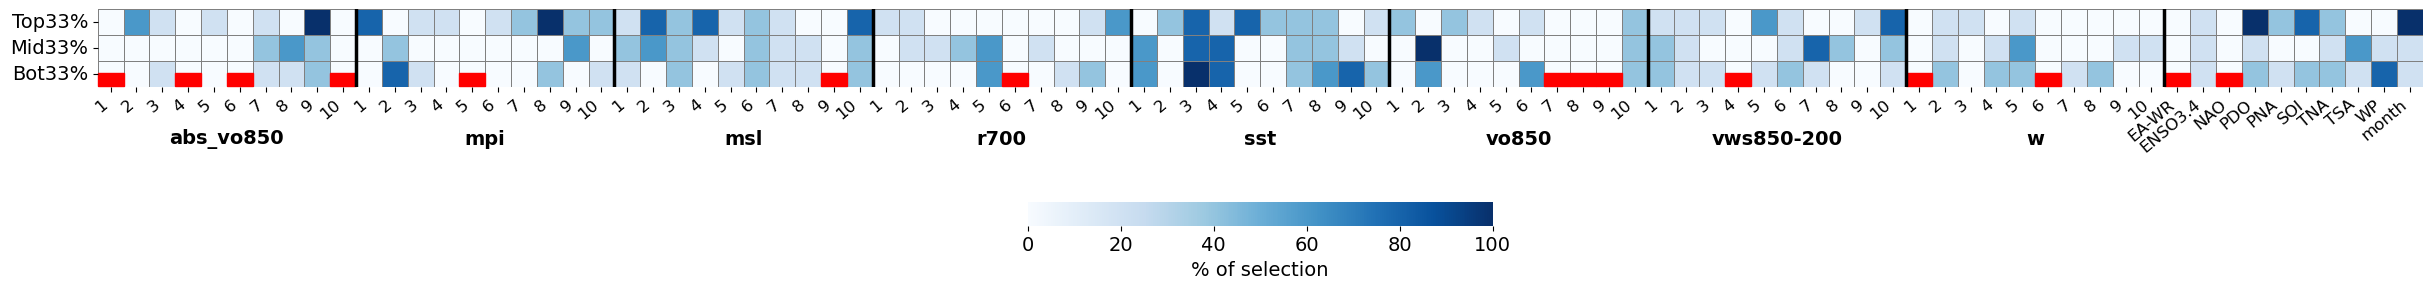

In [24]:
df_tier_sel_perc = pd.DataFrame(0, columns=candidate_variables, index=['Top33%', 'Mid33%', 'Bot33%'])
for r, run_name in enumerate(sorted_df.index):
    model_kind = run_name.split('_')[1]
    sol_filename = f'{model_kind}_{experiment_filename}'
    output_dir = os.path.join(fs_dir, 'results', BASIN, run_name)
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    # Select the variables from the best solutions
    column_names = predictors_df.columns.tolist()
    feat_sel = best_solution[2*len(column_names):]
    if r < 5:
        df_tier_sel_perc.loc['Top33%'] = df_tier_sel_perc.loc['Top33%'] + feat_sel
    elif r < 10:
        df_tier_sel_perc.loc['Mid33%'] = df_tier_sel_perc.loc['Mid33%'] + feat_sel
    else:
        df_tier_sel_perc.loc['Bot33%'] = df_tier_sel_perc.loc['Bot33%'] + feat_sel

df_tier_sel_perc = (df_tier_sel_perc / 5) * 100

# Plot the heatmap
plt.figure(figsize=(3*N_CLUSTERS, 10))
ax = sns.heatmap(df_tier_sel_perc, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                 cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('% of selection', fontsize=14)


# Set xticks labels
features_clustered = [var for var in candidate_variables if 'cluster' in var]
features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
variables = [col.split("_cluster")[0] for col in features_clustered]
variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
xticks_labels = cluster_numbers + features_non_clustered
ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
for i, var in enumerate(sorted(set(variables), key=variables.index)):
    xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + N_CLUSTERS/2
    ax.text(xpos, len(df_tier_sel_perc) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
# Set the vertical lines between the different variables a bit thicker 
thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(N_CLUSTERS)]
for pos in thick_line_pos:
    ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc), linewidth=2.5, color="black")
# Overlay red blocks at the bottom for zero columns
zero_columns = (df_tier_sel_perc == 0).all(axis=0)
for idx, is_zero in enumerate(zero_columns):
    if is_zero:
        ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc) - 0.55), 1, 0.5, color='red', clip_on=False))
# Set yticks labels fontsize
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);

In [25]:
# Load the performance file for the basin with the additional simulations and filter to get the simulation with the best performance
track_file = os.path.join(results_dir, f'sim_performance_extra_{BASIN}.csv')
track_df = pd.read_csv(track_file, index_col=0)
track_df = track_df[track_df.index.str.contains('nd9')]
track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
track_df = track_df[track_df['n_clusters'] == N_CLUSTERS]
# Get the simulation with the best performance
if METRIC == 'COMB':
    higher_is_better = [f'R_Y_{FINAL_MODEL}', f'R_Y_{FINAL_MODEL}_noFS', f'R2_Y_{FINAL_MODEL}', f'R2_Y_{FINAL_MODEL}_noFS']
    lower_is_better = [f'MAE_Y_{FINAL_MODEL}', f'MAE_Y_{FINAL_MODEL}_noFS', f'RMSE_Y_{FINAL_MODEL}', f'RMSE_Y_{FINAL_MODEL}_noFS']
    performance_col = f'COMB_Y_{FINAL_MODEL}'
    performance_col_noFS = f'COMB_Y_{FINAL_MODEL}_noFS'
    track_df[performance_col] = np.zeros(len(track_df))
    track_df[performance_col_noFS] = np.zeros(len(track_df))
    columns_metrics = higher_is_better + lower_is_better
    for column in columns_metrics:
        model_col = column.split('Y_')[1]
        if column in higher_is_better:
            track_df[f'COMB_Y_{model_col}'] += (track_df[column] - track_df[column].min()) / (track_df[column].max() - track_df[column].min())
        else:
            track_df[f'COMB_Y_{model_col}'] += (track_df[column].max() - track_df[column]) / (track_df[column].max() - track_df[column].min())
    sorted_df_extra = track_df.sort_values(performance_col, ascending=False)
else:
    performance_col = f'{METRIC}_Y_{FINAL_MODEL}'
    if METRIC == 'MAE' or METRIC == 'RMSE':
        sorted_df_extra = track_df.sort_values(performance_col, ascending=True)
    else:
        sorted_df_extra = track_df.sort_values(performance_col, ascending=False)
best_sim_extra = sorted_df_extra.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters: {best_sim_extra.name} - {METRIC}_Y: {best_sim_extra[f"{METRIC}_Y_{FINAL_MODEL}"]:.2f}')
# Get the best annual correlation for a model with no features selection
sorted_df_noFS = track_df.sort_values(f'R_Y_{FINAL_MODEL}_noFS', ascending=False)
best_sim_noFS = sorted_df_noFS.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters and no FS: {best_sim_noFS.name} - {METRIC}_Y: {best_sim_noFS[f"{METRIC}_Y_{FINAL_MODEL}_noFS"]:.2f}')

Best NN model for GLB with 10 clusters: test48_pi-lgbm_nc10_nv8_nd9 - R_Y: 0.50
Best NN model for GLB with 10 clusters and no FS: test47_linreg_nc10_nv8_nd9 - R_Y: 0.10


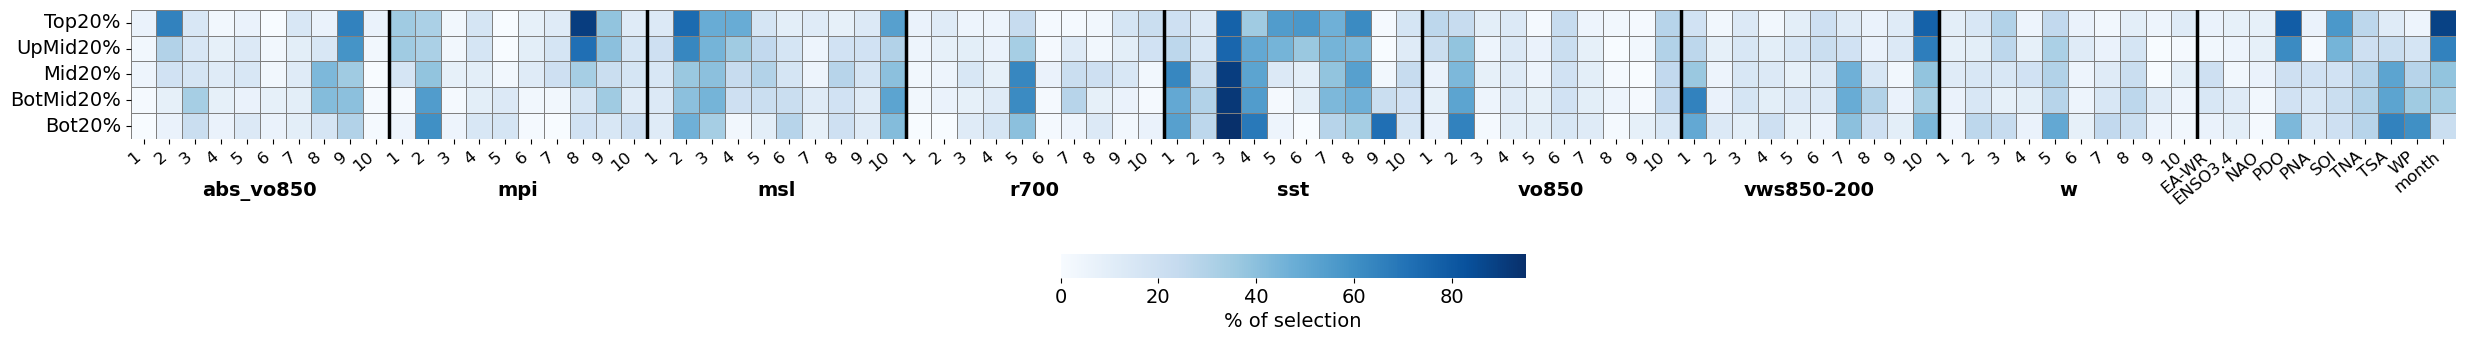

In [26]:
df_tier_sel_perc_extra = pd.DataFrame(0, columns=candidate_variables, index=['Top20%', 'UpMid20%', 'Mid20%', 'BotMid20%', 'Bot20%'])
n_sim = len(sorted_df_extra)
for r, run_name in enumerate(sorted_df_extra.index):
    model_kind = run_name.split('_')[1]
    sol_filename = f'{model_kind}_{experiment_filename}'
    output_dir = os.path.join(fs_dir, 'results', BASIN, run_name)
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    # Select the variables from the best solutions
    column_names = predictors_df.columns.tolist()
    feat_sel = best_solution[2*len(column_names):]
    if r < int(n_sim * 0.2):
        df_tier_sel_perc_extra.loc['Top20%'] = df_tier_sel_perc_extra.loc['Top20%'] + feat_sel
    elif r < int(n_sim * 0.4):
        df_tier_sel_perc_extra.loc['UpMid20%'] = df_tier_sel_perc_extra.loc['UpMid20%'] + feat_sel
    elif r < int(n_sim * 0.6):
        df_tier_sel_perc_extra.loc['Mid20%'] = df_tier_sel_perc_extra.loc['Mid20%'] + feat_sel
    elif r < int(n_sim * 0.8):
        df_tier_sel_perc_extra.loc['BotMid20%'] = df_tier_sel_perc_extra.loc['BotMid20%'] + feat_sel
    else:
        df_tier_sel_perc_extra.loc['Bot20%'] = df_tier_sel_perc_extra.loc['Bot20%'] + feat_sel

df_tier_sel_perc_extra = (df_tier_sel_perc_extra / (n_sim * 0.2)) * 100

plt.figure(figsize=(3*N_CLUSTERS, 10))
ax = sns.heatmap(df_tier_sel_perc_extra, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                 cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('% of selection', fontsize=14)

# Set xticks labels
features_clustered = [var for var in candidate_variables if 'cluster' in var]
features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
variables = [col.split("_cluster")[0] for col in features_clustered]
variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
xticks_labels = cluster_numbers + features_non_clustered
ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
for i, var in enumerate(sorted(set(variables), key=variables.index)):
    xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + N_CLUSTERS/2
    ax.text(xpos, len(df_tier_sel_perc_extra) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
# Set the vertical lines between the different variables a bit thicker 
thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(N_CLUSTERS)]
for pos in thick_line_pos:
    ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc_extra), linewidth=2.5, color="black")
# Overlay red blocks at the bottom for zero columns
zero_columns = (df_tier_sel_perc_extra == 0).all(axis=0)
for idx, is_zero in enumerate(zero_columns):
    if is_zero:
        ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc_extra) - 0.55), 1, 0.5, color='red', clip_on=False))
# Set the yticks labels fontsize
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);

In [27]:
# best_models_perc = df_tier_sel_perc_extra.loc['Top20%']
# df_perc_sel = pd.DataFrame(zip_longest(best_models_perc[best_models_perc >= 50].index.to_list(),
#                                        best_models_perc[best_models_perc >= 60].index.to_list(),
#                                        best_models_perc[best_models_perc >= 75].index.to_list(),
#                                        best_models_perc[best_models_perc >= 90].index.to_list()),
#                                        columns=['50', '60', '75', '90'])
# if CLUSTER_TYPE == '_nc':
#     csv_path = os.path.join(results_dir, f'selected_features_best_models_{BASIN}{CLUSTER_TYPE}{N_CLUSTERS}.csv')
# else:
#     csv_path = os.path.join(results_dir, f'selected_features_best_models_{BASIN}_{CLUSTER_TYPE}{N_CLUSTERS}.csv')
# df_perc_sel.to_csv(csv_path)

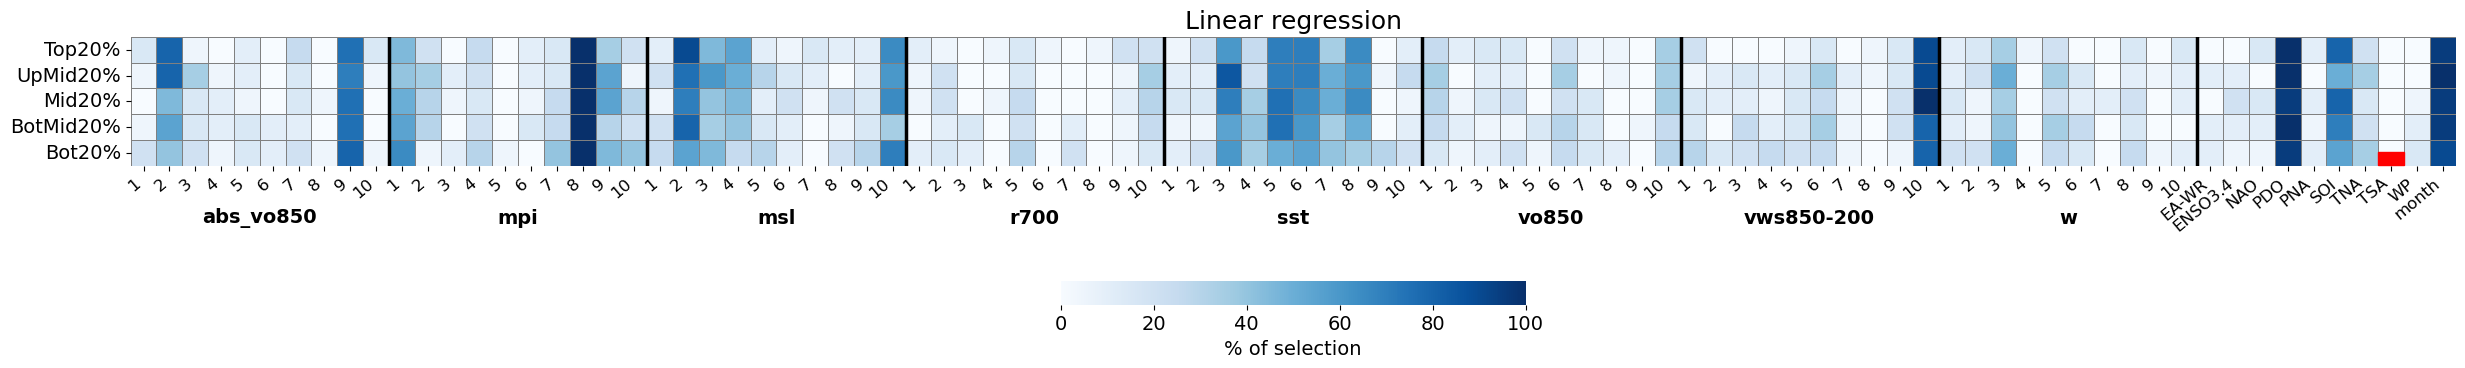

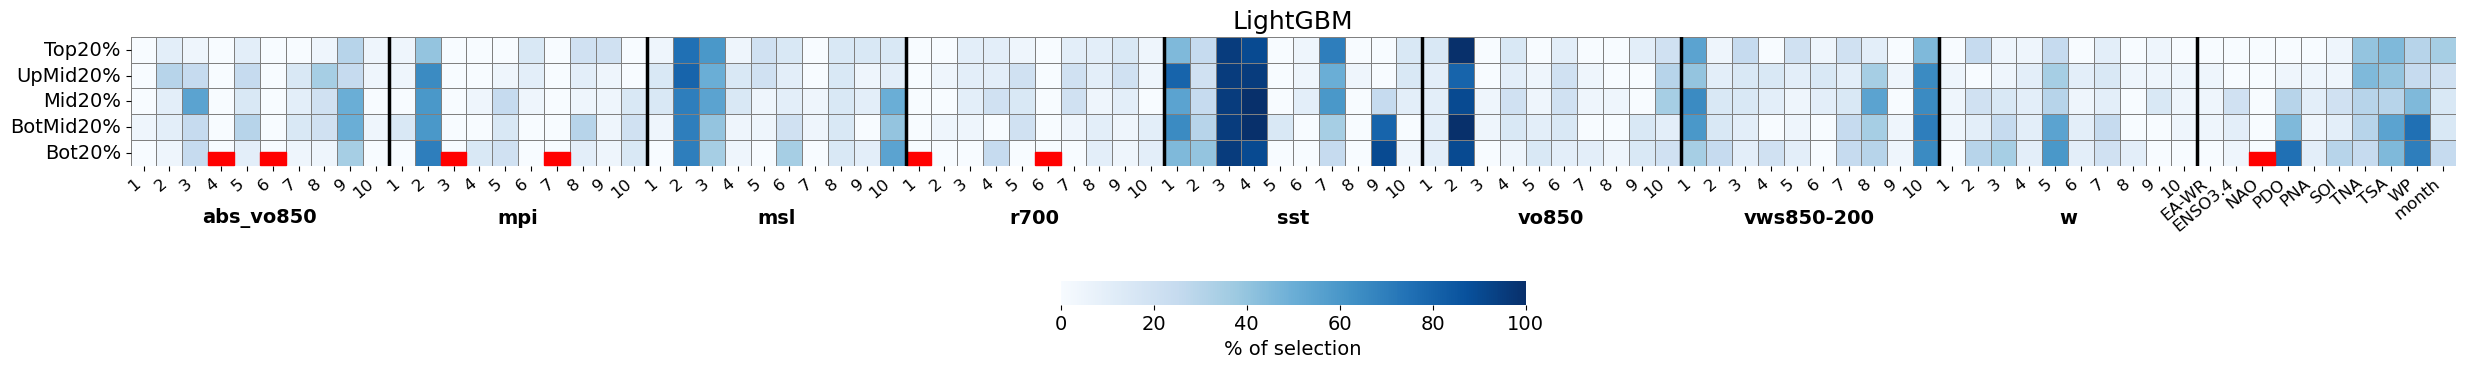

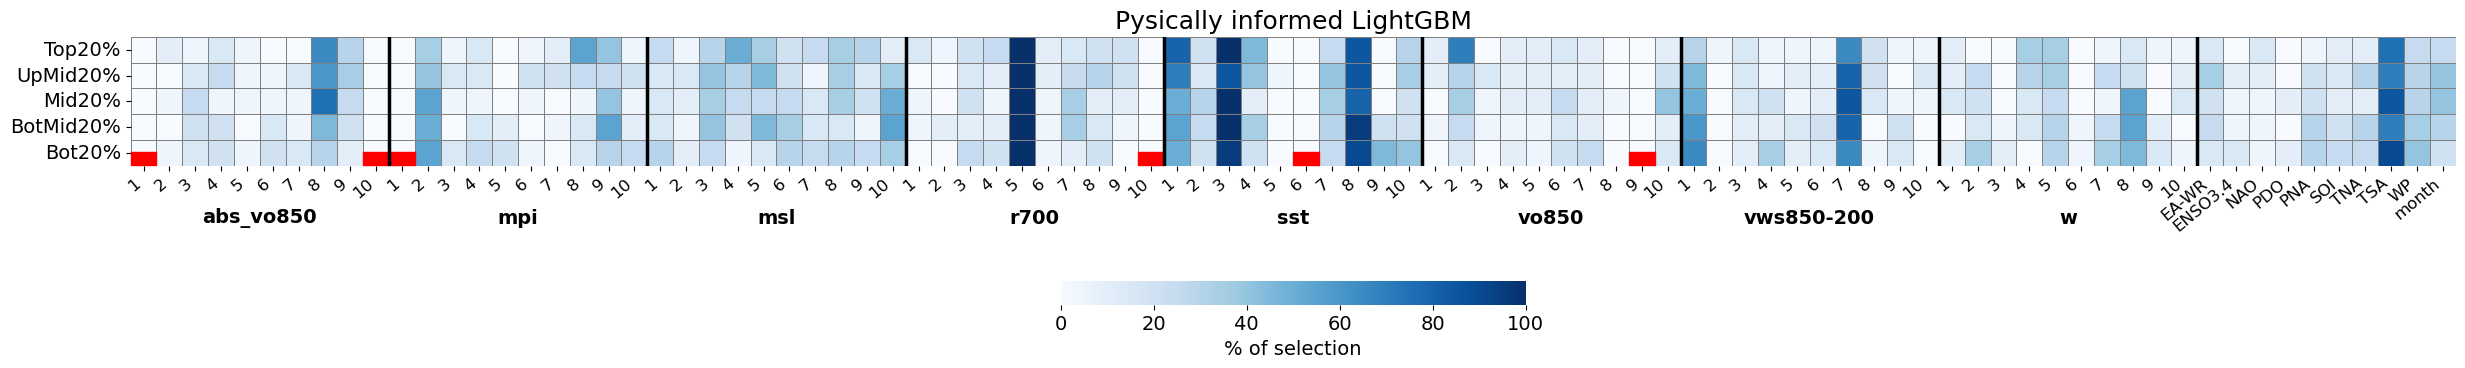

In [39]:
model_kinds = ['linreg', '_lgbm', 'pi-lgbm']
model_names = ['Linear regression', 'LightGBM', 'Pysically informed LightGBM']
for mm, model in enumerate(model_kinds):
    sorted_df_model = sorted_df_extra[sorted_df_extra.index.str.contains(f'{model}')]
    df_tier_sel_perc_model = pd.DataFrame(0, columns=candidate_variables, index=['Top20%', 'UpMid20%', 'Mid20%', 'BotMid20%', 'Bot20%'])
    n_sim = len(sorted_df_model)
    for r, run_name in enumerate(sorted_df_model.index):
        model_kind = run_name.split('_')[1]
        sol_filename = f'{model_kind}_{experiment_filename}'
        output_dir = os.path.join(fs_dir, 'results', BASIN, run_name)
        best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
        best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
        best_solution = best_solution.to_numpy().flatten()
        # Select the variables from the best solutions
        column_names = predictors_df.columns.tolist()
        feat_sel = best_solution[2*len(column_names):]
        if r < int(n_sim * 0.2):
            df_tier_sel_perc_model.loc['Top20%'] = df_tier_sel_perc_model.loc['Top20%'] + feat_sel
        elif r < int(n_sim * 0.4):
            df_tier_sel_perc_model.loc['UpMid20%'] = df_tier_sel_perc_model.loc['UpMid20%'] + feat_sel
        elif r < int(n_sim * 0.6):
            df_tier_sel_perc_model.loc['Mid20%'] = df_tier_sel_perc_model.loc['Mid20%'] + feat_sel
        elif r < int(n_sim * 0.8):
            df_tier_sel_perc_model.loc['BotMid20%'] = df_tier_sel_perc_model.loc['BotMid20%'] + feat_sel
        else:
            df_tier_sel_perc_model.loc['Bot20%'] = df_tier_sel_perc_model.loc['Bot20%'] + feat_sel

    df_tier_sel_perc_model = (df_tier_sel_perc_model / (n_sim * 0.2)) * 100

    plt.figure(figsize=(3*N_CLUSTERS, 10))
    ax = sns.heatmap(df_tier_sel_perc_model, cmap="Blues", linewidths=0.5, linecolor="gray", square=True,
                    cbar_kws={'orientation': 'horizontal', 'label': '% of selection', 'shrink': 0.2, 'aspect': 20})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('% of selection', fontsize=14)
    ax.set_title(f'{model_names[mm]}', fontdict={'fontsize': 18})

    # Set xticks labels
    features_clustered = [var for var in candidate_variables if 'cluster' in var]
    features_non_clustered = [var for var in candidate_variables if 'cluster' not in var]
    cluster_numbers = [col.split("cluster")[-1] if "cluster" in col else "" for col in features_clustered]
    variables = [col.split("_cluster")[0] for col in features_clustered]
    variable_positions = [variables.index(var) for var in sorted(set(variables), key=variables.index)]
    xticks_labels = cluster_numbers + features_non_clustered
    ax.set_xticks(np.arange(len(candidate_variables)) + 0.5)  
    ax.set_xticklabels(xticks_labels, rotation=40, ha="right", fontsize=12)
    for i, var in enumerate(sorted(set(variables), key=variables.index)):
        xpos = variable_positions[i] + (variable_positions[i+1] - variable_positions[i]) / 2 if i < len(variable_positions) - 1 else variable_positions[i] + N_CLUSTERS/2
        ax.text(xpos, len(df_tier_sel_perc_model) + 2, var, ha='center', va='center', fontsize=14, fontweight="bold")
    # Set the vertical lines between the different variables a bit thicker 
    thick_line_pos = [i+1 for i, var in enumerate(candidate_variables) if var.split('_cluster')[-1] == str(N_CLUSTERS)]
    for pos in thick_line_pos:
        ax.vlines(x=pos, ymin=-0.5, ymax=len(df_tier_sel_perc_model), linewidth=2.5, color="black")
    # Overlay red blocks at the bottom for zero columns
    zero_columns = (df_tier_sel_perc_model == 0).all(axis=0)
    for idx, is_zero in enumerate(zero_columns):
        if is_zero:
            ax.add_patch(plt.Rectangle((idx, len(df_tier_sel_perc_model) - 0.55), 1, 0.5, color='red', clip_on=False))
    # Set the yticks labels fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);

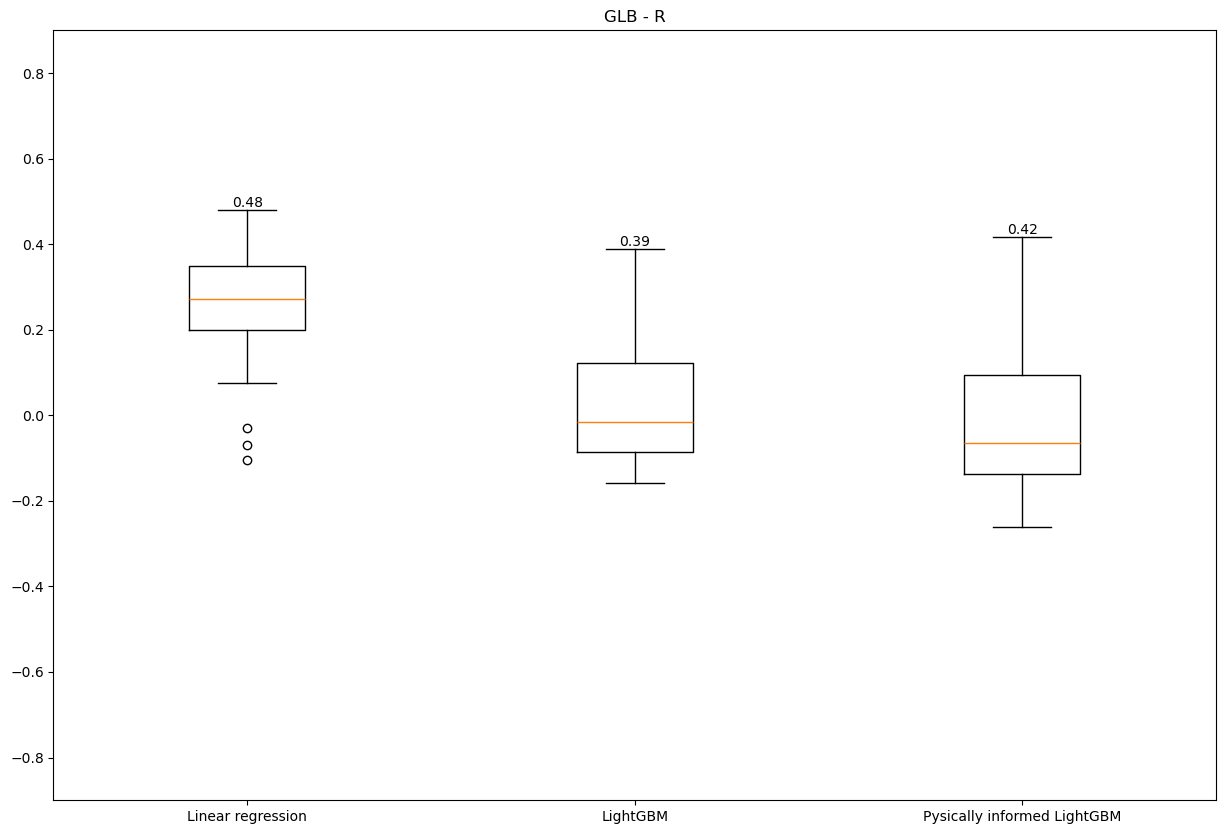

In [38]:
# Boxplot comparing the performances based on the ML model adopted for feature selection
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
basin_name = basin_names[basin_names == BASIN]
# Load file keeping track of the performance of the simulations
track_file = os.path.join(results_dir, f'sim_performance_{BASIN}.csv')
track_df = pd.read_csv(track_file, index_col=0)
track_df = track_df[track_df.index.str.contains('nd9')]
# Filter the track_df to keep only simulations with the anomaly cluster type
track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
# Sort the dataframe by the performance of the chosen final model
if METRIC == 'COMB':
    higher_is_better = [f'R_Y_{FINAL_MODEL}', f'R2_Y_{FINAL_MODEL}']
    lower_is_better = [f'MAE_Y_{FINAL_MODEL}', f'RMSE_Y_{FINAL_MODEL}']
    performance_col = f'COMB_Y_{FINAL_MODEL}'
    track_df[performance_col] = np.zeros(len(track_df))
    columns_metrics = higher_is_better + lower_is_better
    for column in columns_metrics:
        model_col = column.split('Y_')[1]
        if column in higher_is_better:
            track_df[f'COMB_Y_{model_col}'] += (track_df[column] - track_df[column].min()) / (track_df[column].max() - track_df[column].min())
        else:
            track_df[f'COMB_Y_{model_col}'] += (track_df[column].max() - track_df[column]) / (track_df[column].max() - track_df[column].min())
    sorted_df = track_df.sort_values(performance_col, ascending=False)
else:
    performance_col = f'{METRIC}_Y_{FINAL_MODEL}'
    if METRIC == 'MAE' or METRIC == 'RMSE':
        sorted_df = track_df.sort_values(performance_col, ascending=True)
    else:
        sorted_df = track_df.sort_values(performance_col, ascending=False)
# Cycle through the number of clusters and extract the data to plot the boxplot
performances_arrays = []
best_values = []
for mm, model in enumerate(model_kinds):
    model_df = sorted_df[sorted_df.index.str.contains(f'{model}')]
    performances_arrays.append(model_df[performance_col].values)
    best_values.append(model_df.iloc[0][performance_col])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
box = ax.boxplot(performances_arrays, labels=model_names, showfliers=True, patch_artist=False)
# Add the best performance values to the plot
for i, value in enumerate(best_values):
    if METRIC == 'MAE' or METRIC == 'RMSE':
        ax.text(i+1, value, f'{value:.2f}', ha='center', va='top', fontsize=10)
    else:
        ax.text(i+1, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
ax.set_title(f'{BASIN} - {METRIC}')
if METRIC == 'R2' or METRIC == 'R2adj' or METRIC == 'R':
    ax.set_ylim([-0.9, 0.9]);
elif METRIC == 'COMB':
    ax.set_ylim([-0.5, 5]);
plt.show()

In [ ]:
# clusters_fig_dir = os.path.join(data_dir, 'figures')
# for av, atm_var in enumerate(np.unique(variables)):
#     fig_path = os.path.join(clusters_fig_dir, f'{atm_var}.pdf')
#     fig = ut.load_pdf_convert_to_image(fig_path)
#     display(fig)